In [1]:
from fact.io import read_h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
test = read_h5py("data/gamma_test_dl3.hdf5", key="events")
crab = read_h5py("data/open_crab_sample_dl3.hdf5", key="events")

gamma_test = test["gamma_prediction"] >= 0.8
gamma_crab = crab["gamma_prediction"] >= 0.8

In [3]:
# Import and square angle theta of on- and off-positions from dataframe (all off positions flattened to one array)
theta2_s = crab["theta_deg"][gamma_crab].to_numpy()**2
theta2_bg = crab[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]][gamma_crab].to_numpy().flatten()**2

# Create histograms for on- and off-positions 
hist_s, bins_s = np.histogram(theta2_s[theta2_s<=np.sqrt(0.025)], bins=20)
hist_bg, bins_bg = np.histogram(theta2_bg[theta2_bg<=np.sqrt(0.025)], bins=20)

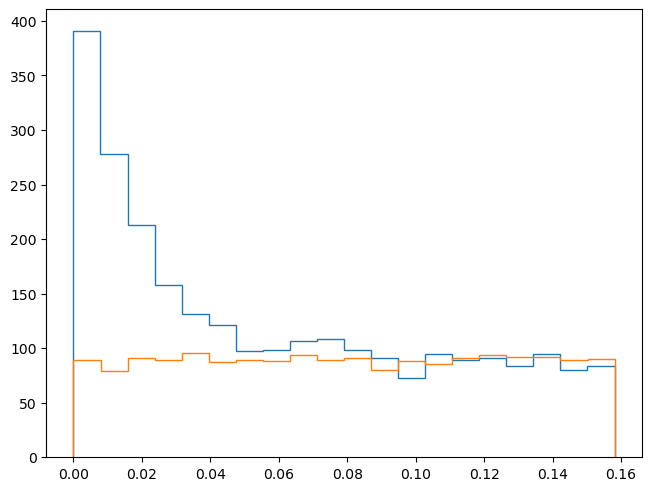

In [4]:
fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(hist_s,bins_s)
ax.stairs(hist_bg/5,bins_bg) # divided by 5 due to 5 off positions -> average over off-positions

plt.show()

In [5]:
# Calculate Number of On- and Off-Events for theta^2 cut of 0.025 
N_on = len(theta2_s[theta2_s<=np.sqrt(0.025)])
N_off = len(theta2_bg[theta2_bg<=np.sqrt(0.025)])

# Alpha is size-factor of on- to off-region
alpha = 0.2

# Calculate significance with Likelihood-Ratio-Test due to Li & Ma
S = np.sqrt(2) * np.sqrt(N_on * np.log( (1+alpha)/alpha * N_on/(N_on + N_off)) + N_off * np.log((1+alpha) * N_off/(N_on + N_off)))
print(S)

15.989754417879428


In [6]:
# Import measured and true energies of events from dataframe
E_true = test["corsika_event_header_total_energy"][gamma_test].to_numpy()
E_pred = test["gamma_energy_prediction"][gamma_test].to_numpy()

# Create logarithmic bin edges for histograms
bins_true=np.logspace(np.log10(600),np.log10(15000),6)
bins_pred=np.logspace(np.log10(600),np.log10(15000),11)

# Add under-/overflow bins
bins_true = np.append(0,bins_true)
bins_true = np.append(bins_true,np.inf)
bins_pred = np.append(0,bins_pred)
bins_pred = np.append(bins_pred,np.inf)

# Create histograms of measured and true data
hist_E_true, bins_E_true = np.histogram(E_true, bins_true)
hist_E_pred, bins_E_pred = np.histogram(E_pred, bins_pred)

In [7]:
# Calculate energy migration matrix as 2D-histogram of measured and true data
A, _, _ = np.histogram2d(E_pred, E_true, bins=[bins_pred, bins_true])

# Normalize A
A = A/np.sum(A,axis=0)
print(np.sum(A,axis=0)) # Check if normalized: should all be 1

# Check if forward folding with A gives the same histogram as measured data (hist_E_pred)
g = A@hist_E_true

# Naive SVD Unfolding
A_inv = np.linalg.pinv(A,rcond=0)

f = A_inv@hist_E_pred

# Log-Likelihood Unfolding
def loglikelihood(f,g):
    for i in range(len(f)):
        L_poisson = -g * np.log((A@f)) + (A@f)
    L_poisson = np.sum(L_poisson)
    return L_poisson

min_l_test = minimize(loglikelihood,f,args=(g),method="Nelder-Mead",tol=1e-8)

[1. 1. 1. 1. 1. 1. 1.]


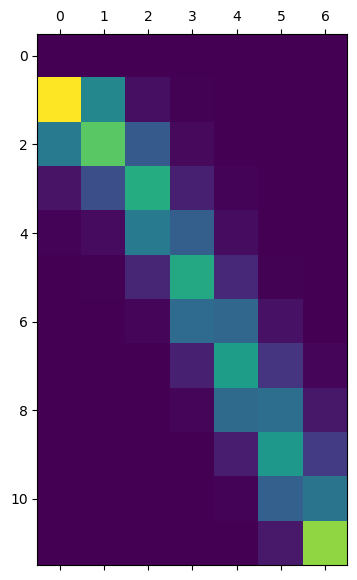

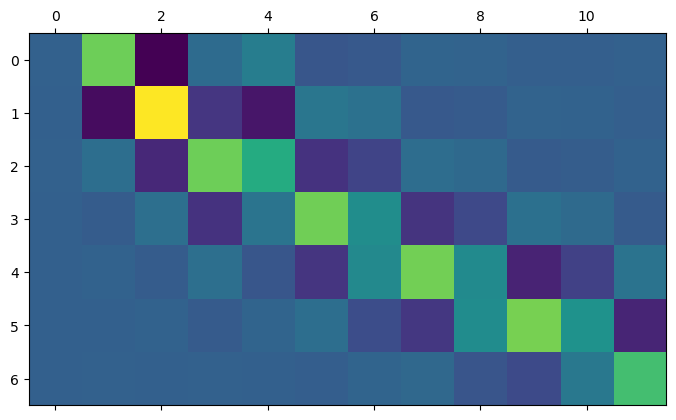

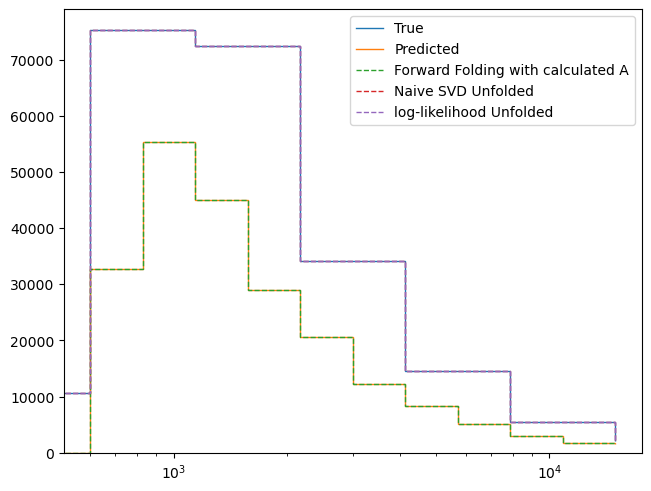

In [8]:
plt.matshow(A)
plt.matshow(A_inv)

fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(hist_E_true,bins_E_true,label="True")
ax.stairs(hist_E_pred,bins_E_pred,label="Predicted")
ax.stairs(g,bins_E_pred,linestyle="--",label="Forward Folding with calculated A")
ax.stairs(f,bins_E_true,linestyle="--",label="Naive SVD Unfolded")
ax.stairs(min_l_test.x,bins_E_true,linestyle="--",label="log-likelihood Unfolded")

ax.set_xscale("log")
ax.legend(loc="best")

plt.show()

In [9]:
# Get Crab Nebula measured Energies
E_crab = crab["gamma_energy_prediction"][gamma_crab].to_numpy()

# Make energy histogram
g_crab, bins_E_crab = np.histogram(E_crab, bins_pred)

# Naive SVD Unfolding
f_crab = A_inv@g_crab

# Poisson Likelihood Unfolding
min_l = minimize(loglikelihood,f_crab,args=(g_crab),method="Nelder-Mead",tol=1e-8)
f_like = min_l.x

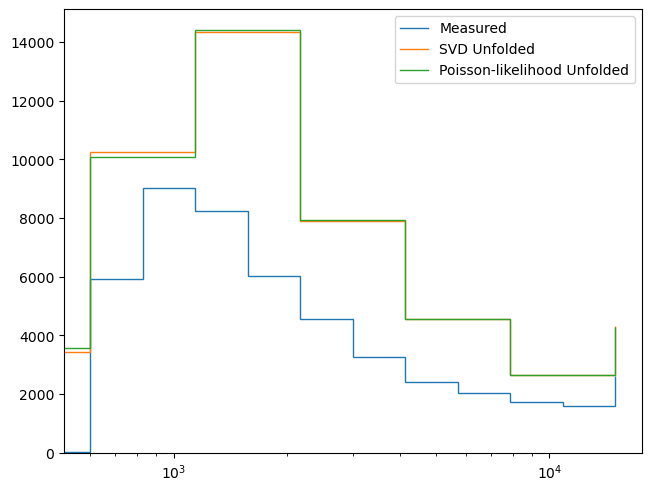

In [10]:
fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(g_crab,bins_E_crab,label="Measured")
ax.stairs(f_crab,bins_E_true,label="SVD Unfolded")
ax.stairs(f_like,bins_E_true,label="Poisson-likelihood Unfolded")

ax.set_xscale("log")
ax.legend(loc="best")

plt.show()